In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# For viewing and manipulating data
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Importing the necessary libraries

import re
import math
import torch
import spacy
import string
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gensim.downloader as api
import matplotlib.pyplot as plt

# Getting particular functions from these libraries 
from scipy import stats
from torch import Tensor
from sklearn.utils import resample
from gensim.models import KeyedVectors # >> alternative to gensim.downloader
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import random_split, DataLoader, TensorDataset, Dataset

# Using the NLTK to tokenize the text
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Checks if a CUDA enabled GPU is available and prints out its information
if torch.cuda.is_available():
    print("CUDA is available!")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        
    device = torch.device("cuda:0")

else:
    print("CUDA is not available.")
    device = torch.device("cpu")

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
reviews_file = ''
w2v_file = ''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file_name = os.path.join(dirname, filename)
        if file_name.endswith('.csv'): 
            reviews_file = file_name
        elif file_name.endswith('.bin') or ('.gz'):
            w2v_file = file_name
        else:
            print(f'Found unexpected file: {file_name}')
                
print(f'Amazon reviews file: {reviews_file}')
print(f'Google news word to vec file: {w2v_file}')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
VERBOSE = False
def printv(text):
    if VERBOSE: print('VERBOSE:', text)
    return

def showV(text):
    '''unconditional verbose output'''
    print('VERBOSE:', text)
    return

DEV = True
def printd(text):
    if DEV: print('DEV:', text)
    return

def showD(text):
    '''unconditional DEV output'''
    print('VERBOSE:', text)
    return

showCellCompletion = False
def showC(text):
    if showCellCompletion:
        print('Cell complete:', text)
    return

import subprocess
showNv = False
accelerator = False

def printNv():
    if not showNv or not accelerator: return
    mem_usage = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE)
    print(mem_usage.stdout.decode('utf-8'))

showMemoryAllocation = True
def printM():
    if not showMemoryAllocation: return
    print(f"Total allocated memory: {torch.cuda.memory_allocated()} bytes")

CUDA is available!
GPU 0: Tesla P100-PCIE-16GB
Amazon reviews file: 
Google news word to vec file: 


In [9]:
class NeuralNetClassifier(nn.Module):
    def __init__(self, r_size, v_size, num_classes, hidden_size=512, num_layers=4, dropout=0.2):
        super(NeuralNetClassifier, self).__init__()
        
        self.hidden_layers = nn.ModuleList()
        self.hidden_layers.append(nn.Linear(r_size * v_size, hidden_size))
        self.hidden_layers.append(nn.BatchNorm1d(hidden_size))
        
        for _ in range(num_layers - 1):
            self.hidden_layers.append(nn.Linear(hidden_size, hidden_size))
            self.hidden_layers.append(nn.BatchNorm1d(hidden_size))
        
        self.output_layer = nn.Linear(hidden_size, num_classes)
        self.relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
            x = self.relu(x)
            x = self.dropout(x)
        
        x = self.output_layer(x)
        return x

# Hyperparameters
hidden_size = 512
num_layers = 4
dropout = 0.2
learning_rate = 0.001
weight_decay = 0.01

# Create an instance of the classifier
classifier = NeuralNetClassifier(seq_len, d_model, num_classes + 1, hidden_size, num_layers, dropout).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(classifier.parameters(), lr=learning_rate, weight_decay=weight_decay)

## Hyperparams

In [2]:
# HyperParameters for the module
d_model = 300  # Should match the embedding dimension of our word embeddings
seq_len = 100  # Maximum sequence length
input_size = d_model  # based on the output size of our feed-forward network

num_layers = 1 # 4 # Number of encoder layers
h       = 1 # 10   # number of attention head
d_ffn   = 2048 # dimension of the feedforward layer

dropout = 0.0 # 0.1  # we can adjust the dropout if needed
eps     = 1e-05 # epsilon value to prevent the standard deviation from becoming zero
learning_rate = 0.01

"""
To ensure compatibility, it's important to choose the 
number of attention heads (h) such that d_model is 
evenly divisible by h in the multi-head attention 
module's self.d_k. This allows for a clean distribution 
of the model dimensionality across the attention heads.
"""

# d_model / attn.h = 300 / 10 = 30

"\nTo ensure compatibility, it's important to choose the \nnumber of attention heads (h) such that d_model is \nevenly divisible by h in the multi-head attention \nmodule's self.d_k. This allows for a clean distribution \nof the model dimensionality across the attention heads.\n"

# Pytorch's Scaled Dot Product Attention

In [3]:
# FROM TORCH.NN.FUNCTIONAL.SCALED_DOT_PRODUCT_ATTENTION DOCS

# Efficient implementation equivalent to the following:
def scaled_dot_product_attention(query, key, value, attn_mask = None, dropout_p = 0.0, is_causal = False, scale = None) -> torch.Tensor:
    # Efficient implementation equivalent to the following:
    L, S = query.size(-2), key.size(-2)
    scale_factor = 1 / math.sqrt(query.size(-1)) if scale is None else scale
    # attn_bias = torch.zeros(L, S, dtype = query.dtype, device = device)
    if is_causal:
        assert attn_mask is None
        temp_mask = torch.ones(L, S, dtype = torch.bool, device = device).tril(diagonal = 0)
        # attn_bias.masked_fill_(temp_mask.logical_not(), float("-inf"))
        # attn_bias.to(query.dtype)

    if attn_mask is not None:
        if attn_mask.dtype == torch.bool:
            attn_bias.masked_fill_(attn_mask.logical_not(), float("-inf"))
        else:
            attn_bias += attn_mask
    attn_weight = query @ key.transpose(-2, -1) * scale_factor
    # attn_weight += attn_bias
    attn_weight = torch.softmax(attn_weight, dim=-1)
    attn_weight = torch.dropout(attn_weight, dropout_p, train=True)
    return attn_weight, attn_weight @ value

# Our Scaled Dot Product Attention

### Mute our tensor generators and use tensors from above implementation

In this modified version, we've removed the linear layers for projecting the input embeddings to query, key, and value tensors. Instead, the forward method now accepts pre-computed query, key, and value tensors as input.

In [4]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=dropout):
        super().__init__()
        
        # Number of attention heads
        self.h = h
        
        # Dimensionality of each attention head
        self.d_k = d_model // h
        
        # Linear layers for output projection
        self.output_linear = nn.Linear(d_model, d_model)
        
        # Dropout layer
        self.dropout = nn.Dropout(p=dropout)

    @staticmethod
    def scaled_dot_product_attention(query, key, value, mask=None, dropout=None):
        # Compute the dimensionality of each attention head
        d_k = query.size(-1)
        
        # Compute the attention scores using the dot product between query and key
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
        
        # Apply the mask to the attention scores (if provided)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        
        # Apply softmax to obtain the attention probabilities
        p_attn = torch.softmax(scores, dim=-1)
        
        # Apply dropout to the attention probabilities (if specified)
        if dropout is not None:
            p_attn = dropout(p_attn)
        
        # Compute the weighted sum of values using the attention probabilities
        # Return the attended values and attention probabilities
        return p_attn, torch.matmul(p_attn, value)

    def forward(self, query, key, value, mask=None):
        # Get the number of batches
        nbatches = query.size(0)
        
        # Reshape the query, key, and value for multi-head attention
#         query = query.view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
#         key = key.view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
#         value = value.view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
        
        # Perform scaled dot-product attention on the projected query, key, and value
        attn_scores, attn_output = self.scaled_dot_product_attention(query, key, value, mask=mask, dropout=self.dropout)
        
        # Reshape the attended output and concatenate the attention heads
        attn_output = attn_output.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        
        # Apply a final linear projection to the concatenated output
        attn_output = self.output_linear(attn_output)

        # Return the attention output
        return attn_scores, attn_output

# Instantiation and Execution

In [5]:
text_embeddings_tensors = torch.rand(10000, 100, 300).to(device)

# Linear projection matrices (takes in 300 dimesions, outputs 300 dimensions)
W_k = nn.Linear(300, 300).to(device)
W_q = nn.Linear(300, 300).to(device)
W_v = nn.Linear(300, 300).to(device)

# Compute key, query, and value tensors
key_tensor   = W_k(text_embeddings_tensors) # shape: (batch_size, max_len, emb)
query_tensor = W_q(text_embeddings_tensors) # shape: (batch_size, max_len, emb)
value_tensor = W_v(text_embeddings_tensors) # shape: (batch_size, max_len, emb)

print(text_embeddings_tensors[0])
print(key_tensor[0])
print(query_tensor[0])
print(value_tensor[0])

tensor([[0.1891, 0.2187, 0.5135,  ..., 0.7158, 0.2512, 0.8328],
        [0.5335, 0.9762, 0.5877,  ..., 0.8307, 0.9632, 0.3409],
        [0.2711, 0.3538, 0.2974,  ..., 0.8718, 0.8018, 0.5976],
        ...,
        [0.9263, 0.5049, 0.6660,  ..., 0.2140, 0.6252, 0.3169],
        [0.6224, 0.8867, 0.2913,  ..., 0.4315, 0.4491, 0.0054],
        [0.7096, 0.8900, 0.8002,  ..., 0.3664, 0.1740, 0.4074]],
       device='cuda:0')
tensor([[-0.3458,  0.2337, -0.2224,  ..., -0.2169,  0.1229,  0.1537],
        [-0.2088,  0.0872, -0.6229,  ..., -0.3335, -0.2886,  0.2108],
        [-0.1188,  0.1965, -0.3754,  ...,  0.1538, -0.1264, -0.0653],
        ...,
        [-0.4379, -0.1846, -0.3463,  ..., -0.3777, -0.4106, -0.2776],
        [-0.4688,  0.0189, -0.2195,  ..., -0.3383, -0.1993,  0.4150],
        [-0.4472,  0.0587, -0.4508,  ..., -0.2043, -0.1601,  0.1996]],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor([[ 0.0172,  0.1071,  0.2651,  ...,  0.2635, -0.3464,  0.0668],
        [ 0.3760,  0.13

In [6]:
# pytorch
attn_weights, attn_output = scaled_dot_product_attention(
    query_tensor, key_tensor, value_tensor)

print(attn_weights.shape)
print(attn_output.shape)
print(attn_weights[0])
print(attn_output[0])

print("Attention Weights (shape:", attn_weights.shape, ")")
print("Attention Scores (shape:", attn_output.shape, ")")

torch.Size([10000, 100, 100])
torch.Size([10000, 100, 300])
tensor([[0.0097, 0.0087, 0.0109,  ..., 0.0100, 0.0102, 0.0099],
        [0.0097, 0.0086, 0.0106,  ..., 0.0096, 0.0107, 0.0100],
        [0.0102, 0.0092, 0.0115,  ..., 0.0094, 0.0107, 0.0100],
        ...,
        [0.0098, 0.0089, 0.0112,  ..., 0.0101, 0.0106, 0.0104],
        [0.0099, 0.0086, 0.0110,  ..., 0.0100, 0.0101, 0.0100],
        [0.0096, 0.0091, 0.0114,  ..., 0.0103, 0.0107, 0.0096]],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor([[-0.1856, -0.0700, -0.5077,  ...,  0.3102,  0.4177, -0.0851],
        [-0.1846, -0.0692, -0.5087,  ...,  0.3107,  0.4180, -0.0849],
        [-0.1851, -0.0696, -0.5081,  ...,  0.3102,  0.4176, -0.0847],
        ...,
        [-0.1857, -0.0689, -0.5078,  ...,  0.3108,  0.4184, -0.0853],
        [-0.1857, -0.0698, -0.5078,  ...,  0.3106,  0.4191, -0.0859],
        [-0.1865, -0.0699, -0.5070,  ...,  0.3104,  0.4191, -0.0855]],
       device='cuda:0', grad_fn=<SelectBackward0>)
Attent

# Visualize

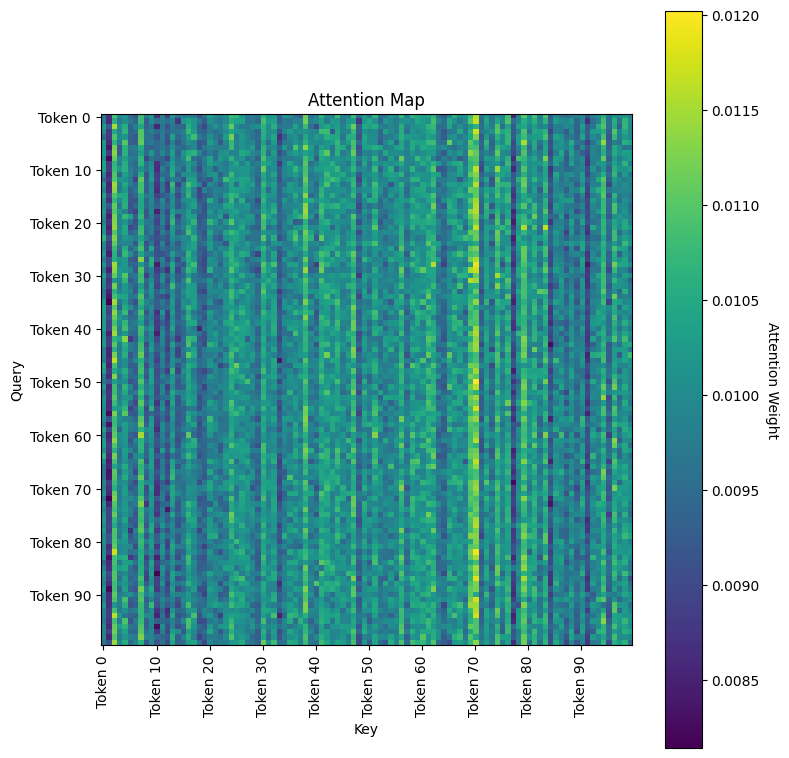

In [7]:
# pytorch

def plot_attention_map(attention_weights, labels = None, figsize = (8, 8), dpi = 100):
    """
    Plots an attention map given the attention weights and optional labels.

    Args:
        attention_weights (torch.Tensor): A square matrix of attention weights.
        labels (list, optional): A list of labels for the tokens. Defaults to None.
        figsize (tuple, optional): The figure size in inches. Defaults to (8, 8).
        dpi (int, optional): The resolution of the figure in dots per inch. Defaults to 100.

    Returns:
        None
    """
    fig, ax = plt.subplots(figsize = figsize, dpi = dpi)
    # remove detach
    im = ax.imshow(attention_weights.cpu().detach().numpy(), cmap = 'viridis')

    if labels:
        step = max(len(labels) // 10, 1)  # Adjust tick frequency based on the number of labels
        ax.set_xticks(range(0, len(labels), step))
        ax.set_yticks(range(0, len(labels), step))
        ax.set_xticklabels(labels[::step], rotation = 90)
        ax.set_yticklabels(labels[::step])

    ax.set_xlabel('Key')
    ax.set_ylabel('Query')
    ax.set_title('Attention Map')
 
    cbar = ax.figure.colorbar(im, ax = ax)
    cbar.ax.set_ylabel('Attention Weight', rotation = -90, va = 'bottom')

    fig.tight_layout()
    plt.show()

# Replace with your actual token labels
labels = ['Token {}'.format(i) for i in range(seq_len)]
plot_attention_map(attn_weights[0], labels)

In [9]:
# ours
our_mha = MultiHeadedAttention(h, d_model, dropout).to(device)

# Use pre-computed query, key, and value tensors
our_attn_weights, our_attn_output = our_mha(
    query_tensor, key_tensor, value_tensor)

print(our_attn_weights.shape)
print(our_attn_output.shape)
print(our_attn_weights[0])
print(our_attn_output[0])

print("Attention Weights (shape:", our_attn_weights.shape, ")")
print("Attention Scores (shape:", our_attn_output.shape, ")")

torch.Size([10000, 100, 100])
torch.Size([10000, 100, 300])
tensor([[0.0097, 0.0087, 0.0109,  ..., 0.0100, 0.0102, 0.0099],
        [0.0097, 0.0086, 0.0106,  ..., 0.0096, 0.0107, 0.0100],
        [0.0102, 0.0092, 0.0115,  ..., 0.0094, 0.0107, 0.0100],
        ...,
        [0.0098, 0.0089, 0.0112,  ..., 0.0101, 0.0106, 0.0104],
        [0.0099, 0.0086, 0.0110,  ..., 0.0100, 0.0101, 0.0100],
        [0.0096, 0.0091, 0.0114,  ..., 0.0103, 0.0107, 0.0096]],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor([[ 0.0941,  0.1324, -0.1716,  ...,  0.1190,  0.2007, -0.1173],
        [ 0.1343,  0.1105, -0.1904,  ...,  0.0596,  0.1476, -0.0623],
        [ 0.2648, -0.0265, -0.0026,  ..., -0.1311, -0.2250,  0.1781],
        ...,
        [-0.0155,  0.0363, -0.1426,  ...,  0.0165,  0.1705, -0.0699],
        [-0.2019, -0.1457, -0.0114,  ..., -0.1546,  0.0531,  0.0291],
        [ 0.5543,  0.0789,  0.0445,  ..., -0.0466, -0.3805,  0.2271]],
       device='cuda:0', grad_fn=<SelectBackward0>)
Attent

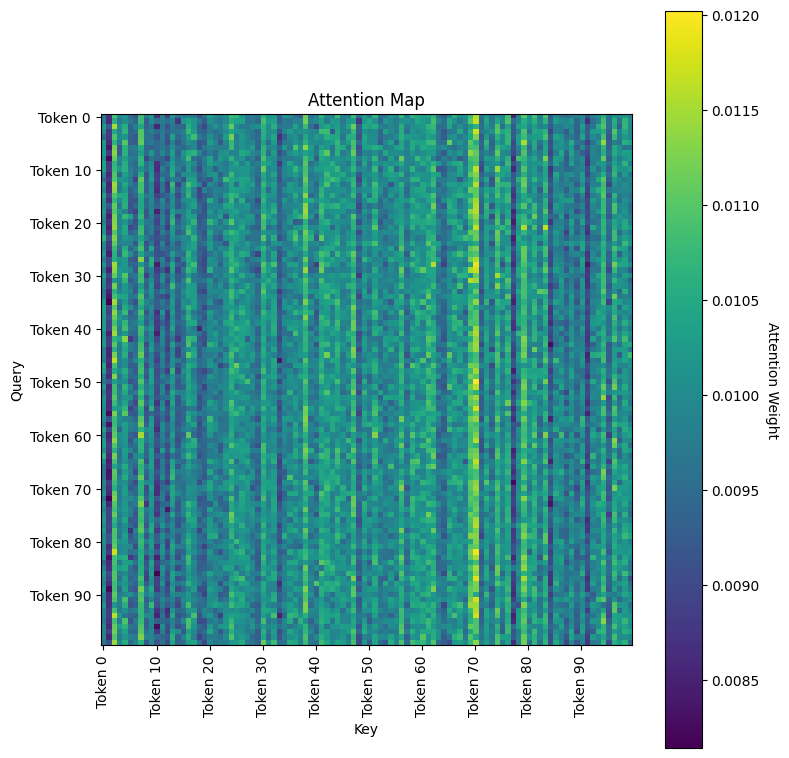

In [11]:
# ours

def plot_attention_map(attention_weights, labels = None, figsize = (8, 8), dpi = 100):
    """
    Plots an attention map given the attention weights and optional labels.

    Args:
        attention_weights (torch.Tensor): A square matrix of attention weights.
        labels (list, optional): A list of labels for the tokens. Defaults to None.
        figsize (tuple, optional): The figure size in inches. Defaults to (8, 8).
        dpi (int, optional): The resolution of the figure in dots per inch. Defaults to 100.

    Returns:
        None
    """
    fig, ax = plt.subplots(figsize = figsize, dpi = dpi)
    # remove detach
    im = ax.imshow(attention_weights.cpu().detach().numpy(), cmap = 'viridis')

    if labels:
        step = max(len(labels) // 10, 1)  # Adjust tick frequency based on the number of labels
        ax.set_xticks(range(0, len(labels), step))
        ax.set_yticks(range(0, len(labels), step))
        ax.set_xticklabels(labels[::step], rotation = 90)
        ax.set_yticklabels(labels[::step])

    ax.set_xlabel('Key')
    ax.set_ylabel('Query')
    ax.set_title('Attention Map')
 
    cbar = ax.figure.colorbar(im, ax = ax)
    cbar.ax.set_ylabel('Attention Weight', rotation = -90, va = 'bottom')

    fig.tight_layout()
    plt.show()

# Replace with your actual token labels
labels = ['Token {}'.format(i) for i in range(seq_len)]
plot_attention_map(our_attn_weights[0], labels)

# Comparison

In [12]:
def cosine_similarity(tensor1, tensor2):
    tensor1_norm = tensor1 / tensor1.norm(dim=-1, keepdim=True)
    tensor2_norm = tensor2 / tensor2.norm(dim=-1, keepdim=True)
    return (tensor1_norm * tensor2_norm).sum(dim=-1)

# cosine, mse, and correlation
similarity = cosine_similarity(attn_weights, our_attn_weights)
mse = torch.mean((attn_weights - our_attn_weights) ** 2)
correlation = torch.corrcoef(torch.stack((attn_weights.view(-1), our_attn_weights.view(-1))))

print("Cosine Similarity:", similarity)
print("Mean Squared Error:", mse)
print("Correlation Coefficient:", correlation[0, 1])

Cosine Similarity: tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        ...,
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
       device='cuda:0', grad_fn=<SumBackward1>)
Mean Squared Error: tensor(1.6097e-19, device='cuda:0', grad_fn=<MeanBackward0>)
Correlation Coefficient: tensor(1., device='cuda:0', grad_fn=<SelectBackward0>)


*Comparing the attention outputs of our scaled dot product function and PyTorch's function is almost similar to comparing the attention outputs of different heads in a multi-head attention system. The differences arise from factors such as random initialization, implementation variations, and numerical precision, but the fundamental principles and functionality of the attention mechanism remain consistent.*

*Random Initialization: The weights of the linear layers used for query, key, and value projections are randomly initialized in both functions. This random initialization leads to different starting points and can result in different attention patterns.*

*Implementation Differences: Although both functions aim to implement the scaled dot product attention mechanism, there might be slight differences in their implementations, such as the order of operations, the use of specific PyTorch functions, or the handling of edge cases. These differences can contribute to variations in the attention outputs.*

*Numerical Precision: The attention outputs can be sensitive to numerical precision, especially when dealing with large input sequences or high-dimensional representations. Differences in numerical precision between our function and PyTorch's function can lead to slight variations in the attention outputs.*